In [1]:
%matplotlib inline
%load_ext line_profiler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose, 
                         Dropout, Cropping2D)
import tensorflow as tf
from keras.optimizers import Adam,SGD
from keras.initializers import he_normal
from keras.models import load_model
from scipy.misc import imresize
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.measure import label as label_shape
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import (Callback, ModelCheckpoint, CSVLogger, 
                             ReduceLROnPlateau)
import keras.backend as K
import itchat
from wechat_utils import SendMessage
import random
from importlib import reload
import pickle
import csv

import pdb
import gc
import sys

Using TensorFlow backend.


/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.8'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train_hq/'
mask_dir = '../data/train_masks/'
data2_dir = '../data2/'
test_dir = '../data/test_hq/'
all_images = os.listdir(data_dir)

In [4]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [7]:
tmp_dir = './tmp/u-net-v4-overfit/'

In [8]:
!mkdir ./tmp/u-net-v4-overfit/

In [10]:
!mkdir ./tmp/u-net-v4-overfit/result

In [12]:
!mkdir ./tmp/u-net-v4-overfit/mask_pred

In [13]:
hard_images = os.listdir('tmp/u-net-v3/result')
hard_images = [hard_image[14:] for hard_image in hard_images]
print (hard_images)

['eb91b1c659a0_02.jpg', '2cb06c1f5bb1_10.jpg', 'f8b6f4c39204_10.jpg', '3afec4b5ac07_09.jpg', 'a46baa0b3ac0_10.jpg', '2f39abb12388_14.jpg', '99639c826ea5_01.jpg', '3a7a8f03e713_09.jpg', '11fcda0a9e1c_09.jpg', '878738468f6b_09.jpg', 'c53e374fdd72_13.jpg', 'bec93f7ddb19_09.jpg', '0d53224da2b7_12.jpg', '430f0cb5666c_04.jpg', 'a46baa0b3ac0_09.jpg', '56023a17481b_09.jpg', '5fb012d30fd9_13.jpg', 'bf9932f7aca8_14.jpg', '3c6acfceb552_12.jpg', '86c10c8c6206_09.jpg']


In [14]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [21]:
# original size 1280, 1918
image_size = [1918, 1280]
input_dims = [1280, 1280]
batch_size = 1

In [22]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [23]:
from data_utils import (read_image_and_mask, show_image_and_mask)

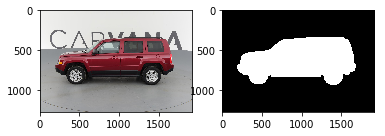

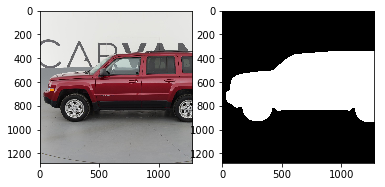

(1280, 1280)


In [24]:
from data_utils import random_crop
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_crop((image_, mask_), input_dims)
show_image_and_mask(image_, mask_)
print (image_.size)

In [25]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = image_.resize(image_size, resample=Image.BILINEAR)
mask_ = mask_.resize(image_size, resample=Image.BILINEAR)

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 52.2 ms


In [26]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

CPU times: user 84 ms, sys: 4 ms, total: 88 ms
Wall time: 88.3 ms


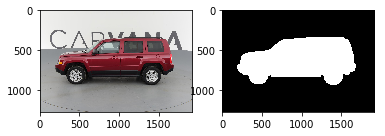

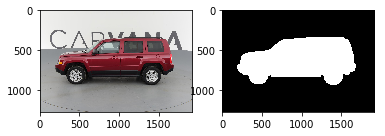

(1918, 1280)


In [27]:
from data_utils import resize_image
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
show_image_and_mask(image_, mask_)
print (image_.size)

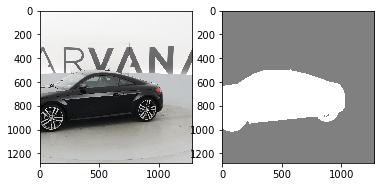

In [28]:
from data_utils import random_horizontal_flip
del globals()['random_horizontal_flip']
from data_utils import random_horizontal_flip
from data_utils import resize_image
del globals()['resize_image']
from data_utils import resize_image

transform_resize = lambda image_pair: resize_image(image_pair, image_size)
transform_flip = lambda image_pair: random_horizontal_flip(image_pair, prob=0.5)
transform_crop = lambda image_pair: random_crop(image_pair, input_dims)
transforms = [transform_resize, transform_flip, transform_crop]

from data_utils import data_gen_small, threadsafe_iter
import data_utils
reload(data_utils)
del globals()['data_gen_small']
from data_utils import data_gen_small
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, hard_images, batch_size, 
                          input_dims, transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [29]:
%%time
train_images_, train_masks_ = next(train_gen)

CPU times: user 148 ms, sys: 12 ms, total: 160 ms
Wall time: 161 ms


In [30]:
print (train_images_.shape)
print (train_masks_.shape)

(1, 1280, 1280, 3)
(1, 1280, 1280, 1)


In [31]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, batch_size, 
                         input_dims, transforms=transforms, in_order=True)

In [32]:
len(validation_images)

1018

In [33]:
for i in tqdm(range(10)):
    val_images, val_masks = next(val_gen)

100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


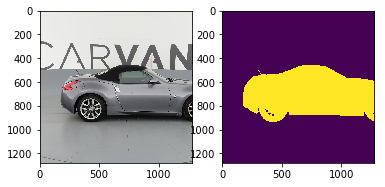

In [34]:
val_images, val_masks = next(val_gen)
show_image_and_mask(val_images[0], val_masks[0,:,:,0])

In [35]:
print (val_images.shape)
print (val_masks.shape)

(1, 1280, 1280, 3)
(1, 1280, 1280, 1)


In [36]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)
print (mask_[0].shape)
print (mask_[0][150][150:180])
print (mask_[0].sum())

(1, 1280, 1280, 3)
(1, 1280, 1280, 1)
(1280, 1280, 1)
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
426013.0


## Build the network

In [27]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True, padding='same', verbose=1):
    conv1 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   input_layer)
    residual = Conv2D(filters, (3, 3), padding=padding, 
                      kernel_initializer=he_normal(), activation='relu')(
                      conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        if verbose:
            print ('Down output shape')
            print ('max_pool {}, residual {}'.format(K.int_shape(max_pool), K.int_shape(residual)))
        return max_pool,residual
    else:
        if verbose:
            print ('Down output shape')
            print ('residual {}'.format(K.int_shape(residual)))
        return residual
    
def up(input_layer, residual, filters, padding='same', cropping=0, verbose=1):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same', 
                    kernel_initializer=he_normal(), activation='relu')(upsample)
    if cropping != 0:
        residual = Cropping2D(cropping=cropping)(residual)

    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding=padding,
                   kernel_initializer=he_normal(), activation='relu')(
                   concat)
    conv2 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   conv1)
    if verbose:
        print ('Up output dims')
        print (K.int_shape(conv2))
    return conv2

In [28]:
def down_block(input_layer, filters_list, dropout_list=None, padding='same'):
    residuals = []
    out = input_layer
    
    if dropout_list is None:
        dropout_list = [0] * len(filters_list)
    
    for i,filters in enumerate(filters_list):
        out, res = down(out, filters, pool=True, padding=padding)
        residuals.append(res)
        if dropout_list[i] > 0:
            out = Dropout(dropout_list[i])(out)
    return out, residuals

def up_block(input_layer, residuals, filters_list, dropout_list=None, padding='same', cropping=None):
    out = input_layer
    
    if padding == 'same':
        cropping = [0] * len(filters_list)
    if dropout_list is None:
        dropout_list = [0] * len(filters_list)
    
    for i, filters in enumerate(filters_list):
        out = up(out, residuals[::-1][i], filters, 
                 padding=padding, cropping=cropping[i])
        if dropout_list[i] > 0:
            out = Dropout(dropout[i])(out)
    return out

In [26]:
K.clear_session()
filters_list = [64, 128, 256, 512]
dropout_list = [0, 0, 0, 0.5]

input_layer = Input(shape=[None, None] + [3])
out, residuals = down_block(input_layer, filters_list, dropout_list)

out = down(out, 1024, pool=False)
out = Dropout(0.5)(out)
out = up_block(out, residuals, filters_list[::-1])

out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(), 
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 64), residual (None, None, None, 64)
Down output shape
max_pool (None, None, None, 128), residual (None, None, None, 128)
Down output shape
max_pool (None, None, None, 256), residual (None, None, None, 256)
Down output shape
max_pool (None, None, None, 512), residual (None, None, None, 512)
Down output shape
residual (None, None, None, 1024)
Up output dims
(None, None, None, 512)
Up output dims
(None, None, None, 256)
Up output dims
(None, None, None, 128)
Up output dims
(None, None, None, 64)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None,

In [34]:
K.clear_session()
filters_list_1 = [36, 72, 144, 288]
filters_list_2 = filters_list_1

input_layer = Input(shape=[None, None, 3])
out, residuals_1 = down_block(input_layer, filters_list_1)
out, residuals_2 = down_block(out, filters_list_2)
out = down(out, 64, pool=False)
out = up_block(out, residuals_2, filters_list_2[::-1])
out = up_block(out, residuals_1, filters_list_1[::-1])
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(),
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 72), residual (None, None, None, 72)
Down output shape
max_pool (None, None, None, 144), residual (None, None, None, 144)
Down output shape
max_pool (None, None, None, 288), residual (None, None, None, 288)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 72), residual (None, None, None, 72)
Down output shape
max_pool (None, None, None, 144), residual (None, None, None, 144)
Down output shape
max_pool (None, None, None, 288), residual (None, None, None, 288)
Down output shape
residual (None, None, None, 64)
Up output dims
(None, None, None, 288)
Up output dims
(None, None, None, 144)
Up output dims
(None, None, None, 72)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 288)
Up output dims
(None, None, None, 144)
Up output dims
(None, None, None, 72)
Up outpu

In [49]:
K.clear_session()
filters_list_1 = [36, 36, 36, 36]
filters_list_2 = filters_list_1

input_layer = Input(shape=[None, None, 3])
out, residuals_1 = down_block(input_layer, filters_list_1)
out, residuals_2 = down_block(out, filters_list_2)
out = down(out, 64, pool=False)
out = up_block(out, residuals_2, filters_list_2[::-1])
out = up_block(out, residuals_1, filters_list_1[::-1])
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(),
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
residual (None, None, None, 64)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 36)
Up output dims
(None

In [ ]:
# Parameters distribution
# For convnet, parameters number = size_w * size_h * pre_depth * 
# curr_depth
# increase intial depth by 2 will result 4x params 
# Down 
# 2k 37k
# 74k 148k
# 295k 590k
# 1180k 2400k
# 4720k 9438k
# Up
# 2098k 4719k 2360k
# 524k 1180k 590k
# 131k 295k 148k
# 33k 74k 37k
# 0k last 1x1 conv
# Total, 31032k

In [ ]:
# Computation (multiply) 
# Down
# 3 * 64 * 9 * 570^2 = 561m
# 64 * 64 * 9 * 568^2 = 11893m
# 64 * 128 * 9 * 280^2 * 3 = 17340m
# 128 * 256 * 9 * 136^2 * 3 = 16264m
# 256 * 512 * 9 * 64^2 * 3 = 14496m
# 512 * 1024 * 9 * 28^2 * 3 = 11098m
# Down in all, 71652m
# Up
# 1024 * 512 * 4 * 56^2 = 6576m
# 1024 * 512 * 9 * 52^2 * 1.5 = 19139m
# 512 * 256 * 4 * 104^2 = 5671m
# 512 * 256 * 9 * 100^2 * 1.5 = 17695m
# 256 * 128 * 4 * 200^2 = 5243m
# 256 * 128 * 9 * 196^2 * 1.5 = 16994m
# 128 * 64 * 4 * 392^ 2 = 5035m
# 128 * 64 * 9 * 388^2 * 1.5 = 16648m
# Up in all, 93001m
# Omit last 1x1 conv and activation
# Total, 164653m ~ 0.16T
# Every layer, computation is almost the same, becasue the size decrease
# by a factor of 2, while filter increase by factor of 2
# Increase the filter size will significantly increase the computation
# Increase input size by 2, the number of multiplication will x4
# Increase intial depth by 2, the number of mutiplication will x4

In [29]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

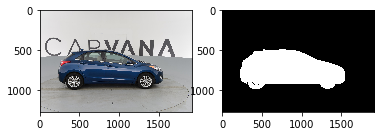

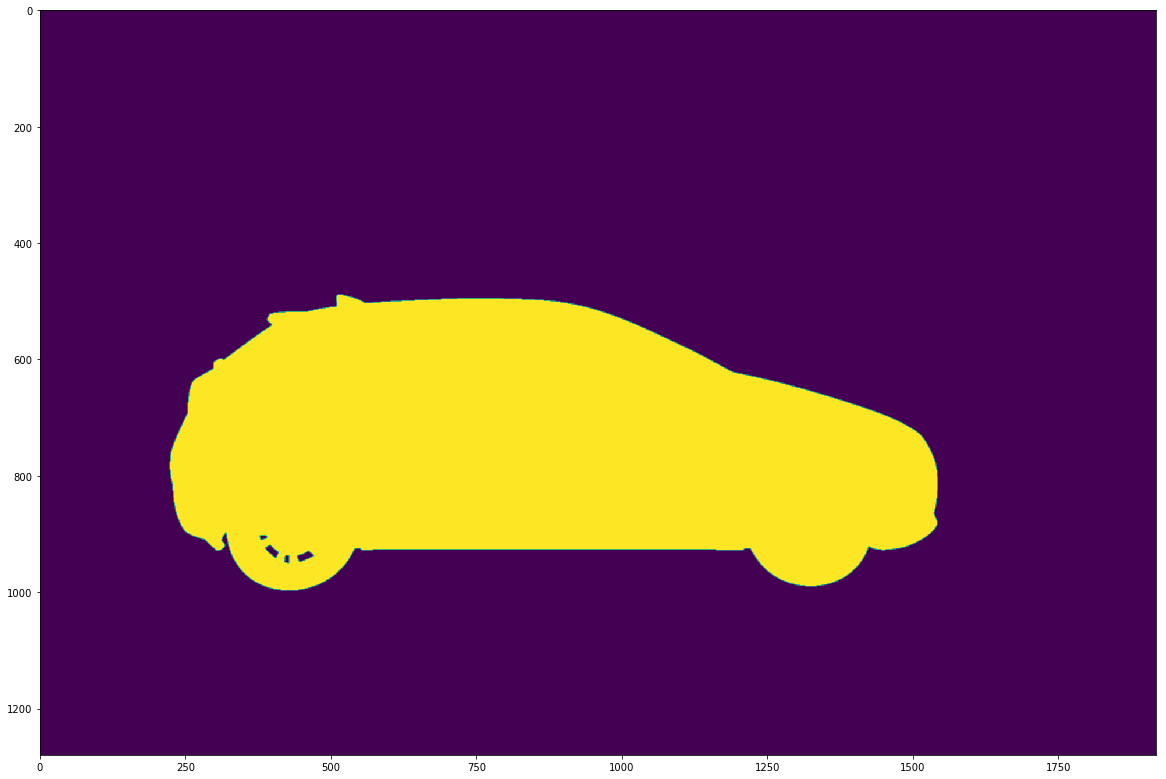

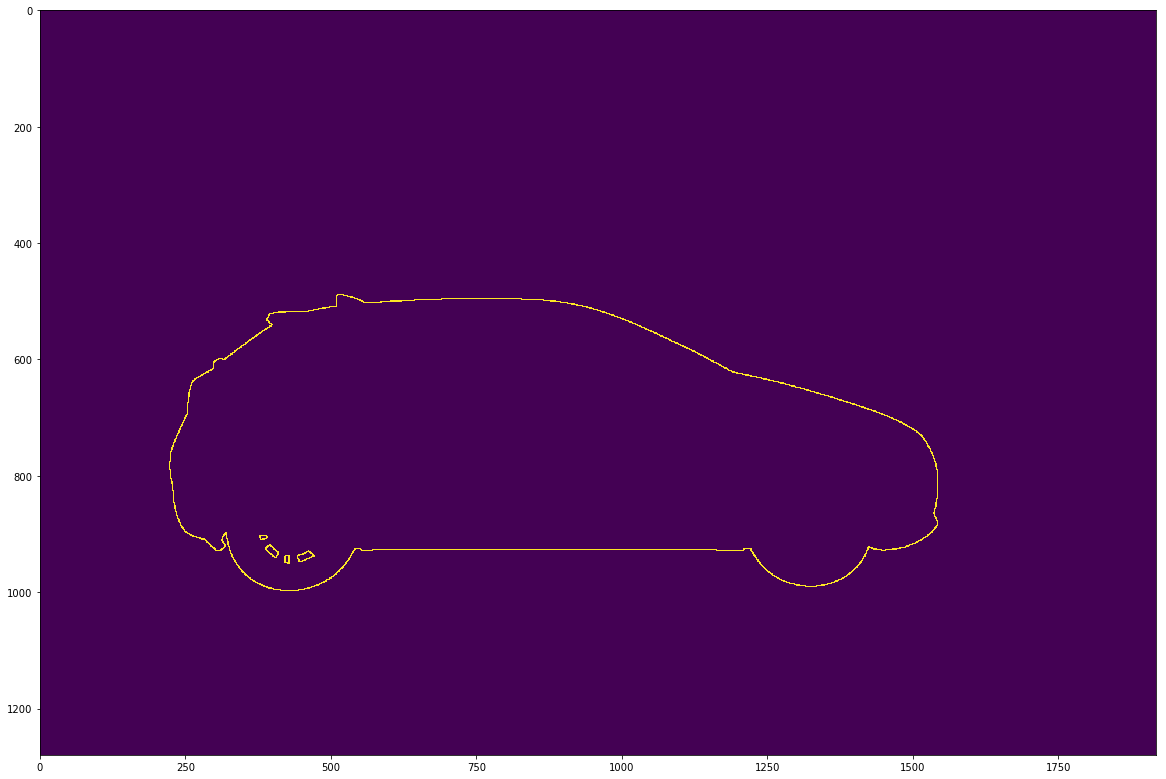

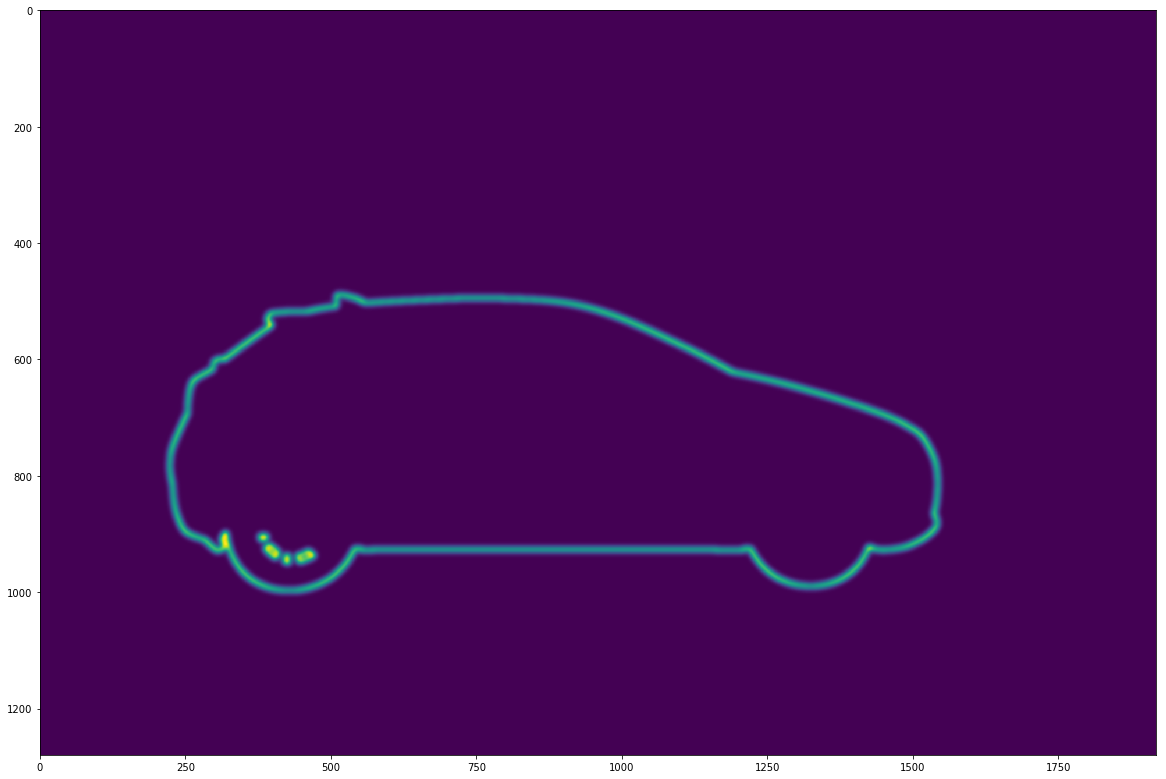

In [30]:
def tf_detect_edge(y_true, kernel_size=3, verbose=0):
    y_true_round = tf.round(y_true)
    edge_detector = tf.reshape(shape=(kernel_size, kernel_size, 1, 1), 
                               tensor=tf.ones(kernel_size**2))
    y_true_conv = tf.nn.conv2d(y_true_round, edge_detector, (1,1,1,1), 
                               'SAME', name='edge_detector')
    y_true_conv = tf.round(y_true_conv)
    condition1 = tf.equal(y_true_conv, 0.)
    condition2 = tf.equal(y_true_conv, kernel_size**2.)
    condition = tf.logical_or(condition1, condition2)
    edge = tf.where(condition, 
                    tf.zeros_like(y_true_conv), tf.ones_like(y_true_conv))
    if verbose:
        return y_true_conv ,edge
    else:
        return edge

def tf_gaussian_blur(edge, sigma=5):
    from scipy.ndimage import gaussian_filter
    kernel = np.zeros((sigma*8+1, sigma*8+1))
    kernel[sigma*4, sigma*4] = 1
    kernel = gaussian_filter(kernel, sigma)
    kernel = tf.constant(dtype=tf.float32, value=kernel)
    kernel = tf.reshape(shape=(sigma*8+1, sigma*8+1, 1, 1), tensor=kernel)
    blurred = tf.nn.conv2d(edge, kernel, (1,1,1,1), 'SAME', name='blur')
    return blurred

def test_tf_blur(mask):
    ph_mask = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    y_true_conv, edge = tf_detect_edge(ph_mask, verbose=1)
    blurred = tf_gaussian_blur(edge)
    with tf.Session() as sess:
        out = sess.run([y_true_conv, edge, blurred], feed_dict={ph_mask: mask})
    np.savetxt('edge.txt', out[0][0][:,:,0])
    plt.figure(figsize=(20, 16))
    plt.imshow(out[0][0][:,:,0])
    plt.show()
    plt.figure(figsize=(20, 16))
    plt.imshow(out[1][0][:,:,0])
    plt.show()
    plt.figure(figsize=(20, 16))
    plt.imshow(out[2][0][:,:,0])
    plt.show()    

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_ = img_to_array(mask_)
test_tf_blur(mask_[None,:,:,0][:,:,:,None]/255)

In [31]:
# Custome loss
def weighted_binary_crossentropy(y_true, y_pred):
    """
    # Args:
    y_true:      (batch_size, high, width, channel)
    """
    class_weight = 1
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
    # Calculate weight
    edge = tf_detect_edge(y_true)
    blurred = tf_gaussian_blur(edge)
    boundry_weight = 10
    weight_map = 1 + (class_weight - 1) * y_true + boundry_weight * blurred
    crossentropy = - y_true * tf.log(y_pred) - (1 - y_true) * tf.log(1 - y_pred)
    weighted_loss = K.mean(crossentropy * weight_map, axis=-1)
    
    return weighted_loss

def test_weighted_loss():
    y_true = np.random.choice([0,1], size=(1,4,4,1))
    y_pred = np.random.uniform(size=(1,4,4,1))
    ph_true = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    ph_pred = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    op_loss = weighted_binary_crossentropy(ph_true, ph_pred)
    
    from keras.losses import binary_crossentropy
    op_naive_loss = binary_crossentropy(ph_true, ph_pred)
    with tf.Session() as sess:
        loss = sess.run([op_loss, op_naive_loss], feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('weigted loss')
        print (loss[0])
        print ('naive loss')
        print (loss[1])
        loss = sess.run(K.mean(K.binary_crossentropy(ph_true, ph_pred), axis=-1), 
                        feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('naive loss 2')
        print (loss)
        loss = sess.run(K.mean(-ph_true * tf.log(ph_pred) - (1 - ph_true) * tf.log(1 - ph_pred), axis=-1), 
                        feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('loss with prob 2')
        print (loss)
test_weighted_loss()

weigted loss
[[[ 3.52485514  0.90600181  0.44623813  1.55993342]
  [ 1.73317134  0.16943006  3.57464027  2.56359029]
  [ 0.38178372  2.94783592  0.27500147  3.76601982]
  [ 0.02865751  0.7545374   1.77094853  3.65923381]]]
naive loss
[[[ 1.93014884  0.48658338  0.2391928   0.84931463]
  [ 0.93082863  0.089219    1.87882066  1.369259  ]
  [ 0.20464388  1.54937398  0.14428557  2.00824213]
  [ 0.01560276  0.4030118   0.94436377  1.98283374]]]
naive loss 2
[[[ 1.93014884  0.48658338  0.2391928   0.84931463]
  [ 0.93082863  0.089219    1.87882066  1.369259  ]
  [ 0.20464388  1.54937398  0.14428557  2.00824213]
  [ 0.01560276  0.4030118   0.94436377  1.98283374]]]
loss with prob 2
[[[ 1.93014896  0.48658338  0.23919278  0.84931463]
  [ 0.93082863  0.08921899  1.87882066  1.369259  ]
  [ 0.20464389  1.54937398  0.14428556  2.00824213]
  [ 0.01560274  0.40301183  0.94436383  1.98283362]]]


In [32]:
def threshold_mask(mask):
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

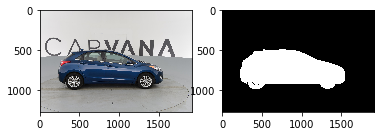

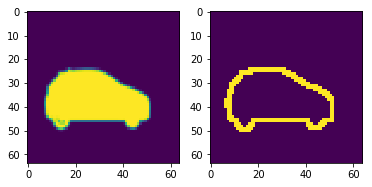

304437bad7ff_13.jpg


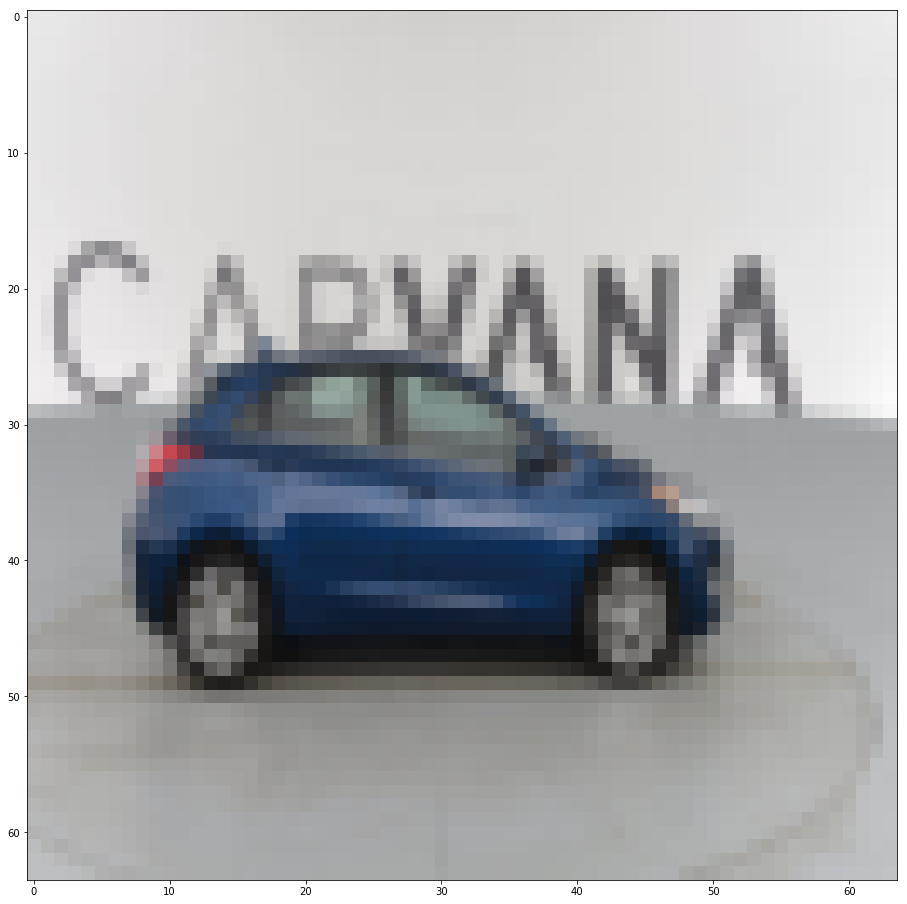

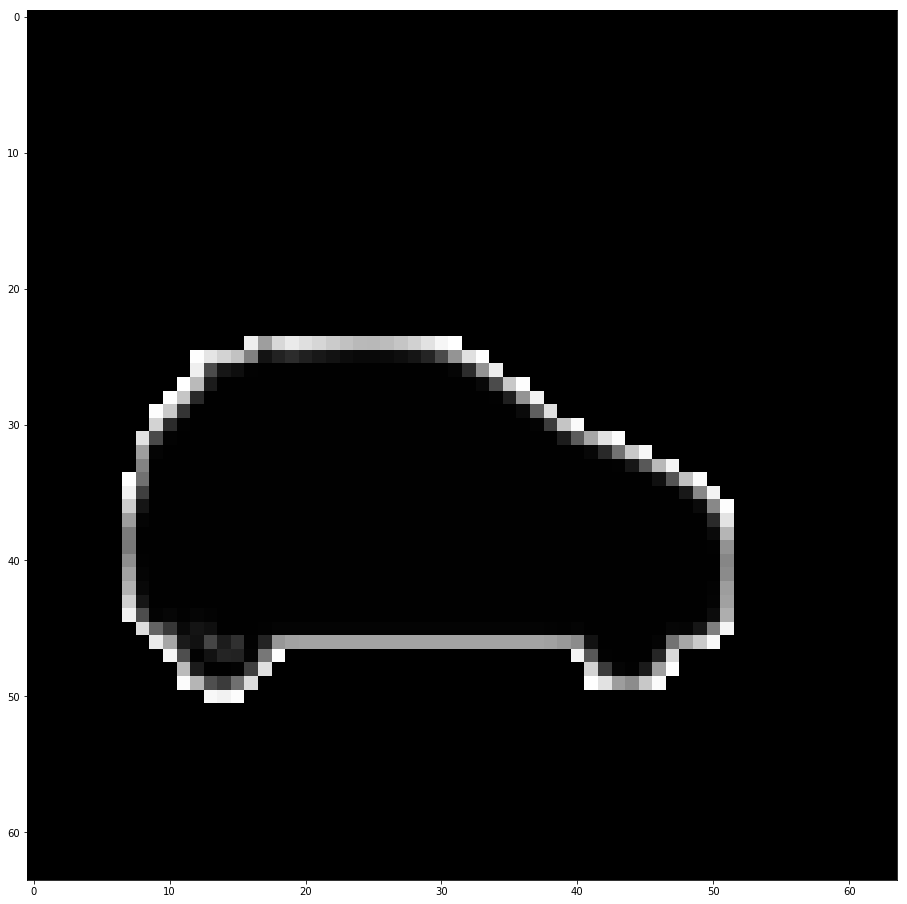

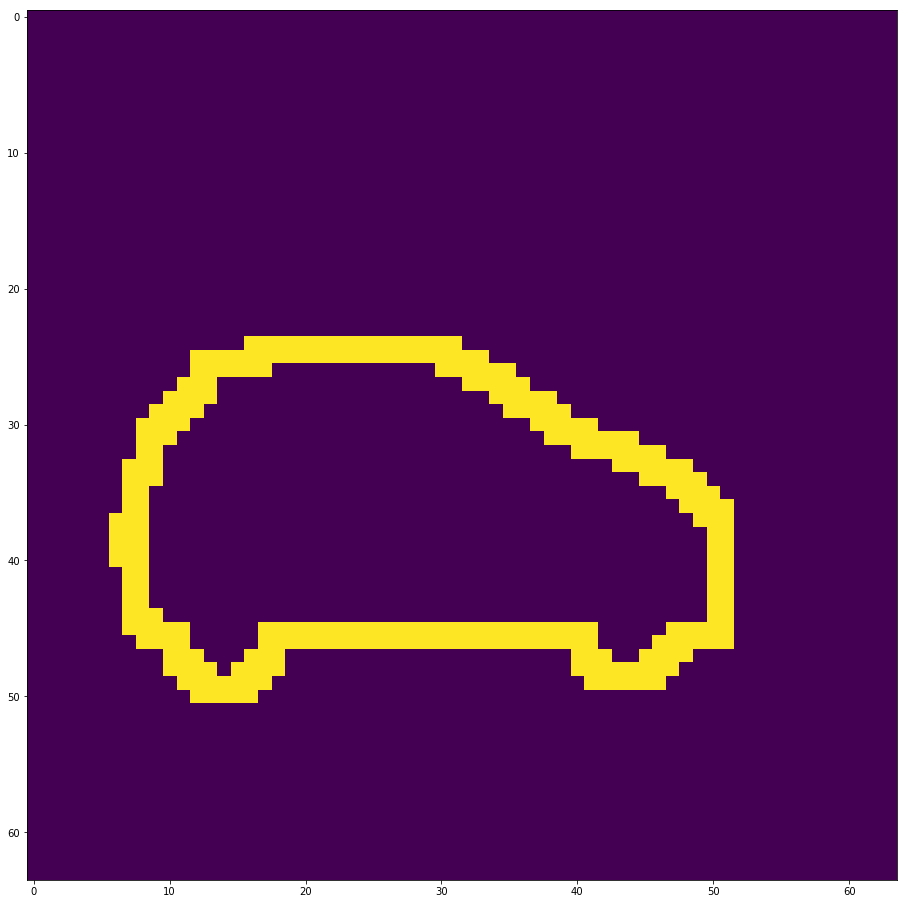

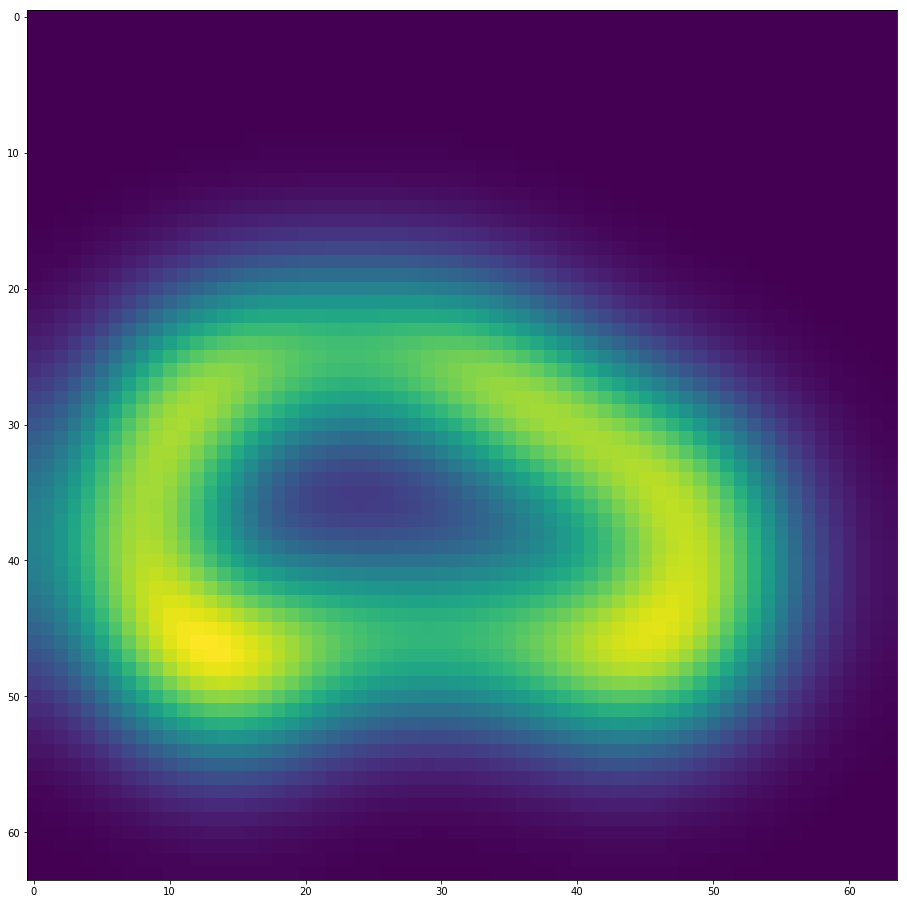

In [33]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
def detect_edge(mask, kernel_size=3, verbose=0):
    """
    # Args:
    mask:      2D array
    """
    edge_detector = np.ones(kernel_size**2).reshape((kernel_size, kernel_size))
    mask_conv = convolve2d(mask, edge_detector, 'same', 'symm')
    edge = np.ones_like(mask)
    if verbose:
        print ('show intermediate')
        plt.figure(figsize=(20, 16))
        plt.imshow(mask_conv)
        plt.show()
        np.savetxt('edge.txt', np.round(mask_conv))
    edge[mask_conv==0] = 0
    edge[mask_conv==kernel_size**2] = 0
    return edge
    
def gaussian_blur(mask, sigma=5):
    #return gaussian_filter(mask, 5)
    kernel = np.zeros((sigma*8+1, sigma*8+1))
    kernel[sigma*4, sigma*4] = 1
    kernel = gaussian_filter(kernel, sigma)
    blurred = convolve2d(mask, kernel, 'same', 'symm')
    return blurred

image_size = (64, 64)
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_ = img_to_array(mask_)
edge_ = detect_edge(threshold_mask(mask_[:,:,0]/255.))
show_image_and_mask(mask_[:,:,0], edge_)
#np.savetxt('edge.txt', threshold_mask(mask_[:,:,1]/255.))
print (validation_images[1])
plt.figure(figsize=(20, 16))
plt.imshow(image_)
plt.show()
plt.figure(figsize=(20, 16))
plt.imshow(mask_)
plt.show()
plt.figure(figsize=(20, 16))
plt.imshow(edge_)
plt.show()

edge_ = gaussian_blur(edge_)
plt.figure(figsize=(20, 16))
plt.imshow(edge_)
plt.show()

In [34]:
image_size = [1918, 1280]
input_dims = [1280, 1280]
batch_size = 1

## Original Model

In [41]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef')
send_message = SendMessage(fexten='tmp_dir')

Getting uuid of QR code.


██████████████████████████████████████████████████████████████████████████████
██              ████    ██  ██  ██████████████████  ██  ██████              ██
██  ██████████  ██    ████    ████████  ████    ██  ██  ██████  ██████████  ██
██  ██      ██  ██      ██  ██            ████    ██        ██  ██      ██  ██
██  ██      ██  ██  ████  ██████        ██      ██    ██  ████  ██      ██  ██
██  ██      ██  ██        ████████████    ██████  ████  ██  ██  ██      ██  ██
██  ██████████  ██  ████████████    ██        ████  ██  ██  ██  ██████████  ██
██              ██  ██  ██  ██  ██  ██  ██  ██  ██  ██  ██  ██              ██
████████████████████  ██    ██      ██    ██  ████████      ██████████████████
██████  ████            ████  ████    ████    ████████  ████  ██          ████
██  ██  ██    ██  ██    ██  ██████  ██  ████              ████  ████████    ██
████████            ████          ██  ██  ██  ██████████  ██    ██████  ██  ██
██    ██      ██  ████████    ██████      ██      ██

Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as LUO FAN


In [42]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, 
             metrics=[dice_coef])

In [43]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=2, 
                              callbacks=[checkpoint, csv_logger], 
                              validation_data=(val_images[0:2], val_masks[0:2]), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=2, callbacks=[<keras.ca..., validation_data=(array([[[..., validation_steps=inf, workers=1, epochs=2, initial_epoch=0, max_queue_size=6)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/2
2/2 [==============================] - 9s - loss: 0.7175 - dice_coef: 0.2933 - val_loss: 0.7172 - val_dice_coef: 0.1311
Epoch 2/2
2/2 [==============================] - 2s - loss: 0.6922 - dice_coef: 0.1403 - val_loss: 0.6961 - val_dice_coef: 0.0515


In [44]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              max_q_size=6, 
                              workers=1, 
                              epochs=100, 
                              initial_epoch=0)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=20.0, callbacks=[<keras.ca..., workers=1, epochs=100, initial_epoch=0, max_queue_size=6)`
  


Epoch 1/100
20/20 [==============================] - 19s - loss: 0.5608 - dice_coef: 0.0060    

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:889: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_dice_coef` which is not available. Available metrics are: loss,dice_coef,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 2/100
20/20 [==============================] - 19s - loss: 0.5553 - dice_coef: 0.0000e+00    
Epoch 3/100
20/20 [==============================] - 19s - loss: 0.5293 - dice_coef: 0.0000e+00    
Epoch 4/100
20/20 [==============================] - 19s - loss: 0.5579 - dice_coef: 0.0000e+00    
Epoch 5/100
20/20 [==============================] - 19s - loss: 0.5232 - dice_coef: 7.2753e-06    
Epoch 6/100
20/20 [==============================] - 19s - loss: 0.4728 - dice_coef: 1.1505e-04    
Epoch 7/100
20/20 [==============================] - 20s - loss: 0.5654 - dice_coef: 0.2309    
Epoch 8/100
20/20 [==============================] - 20s - loss: 0.4980 - dice_coef: 0.4590    
Epoch 9/100
20/20 [==============================] - 20s - loss: 0.5522 - dice_coef: 0.3553    
Epoch 10/100
20/20 [==============================] - 20s - loss: 0.4924 - dice_coef: 0.5582    
Epoch 11/100
20/20 [==============================] - 20s - loss: 0.5141 - dice_coef: 0.4818    
Epoch 12/100
20/2

In [45]:
history2 = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              max_q_size=6, 
                              workers=1, 
                              epochs=200, 
                              initial_epoch=100)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=20.0, callbacks=[<keras.ca..., workers=1, epochs=200, initial_epoch=100, max_queue_size=6)`
  import sys


Epoch 101/200
20/20 [==============================] - 19s - loss: 0.0672 - dice_coef: 0.9679    

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:889: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_dice_coef` which is not available. Available metrics are: loss,dice_coef,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 102/200
20/20 [==============================] - 18s - loss: 0.0714 - dice_coef: 0.9627    
Epoch 103/200
20/20 [==============================] - 19s - loss: 0.0707 - dice_coef: 0.9625    
Epoch 104/200
20/20 [==============================] - 19s - loss: 0.0784 - dice_coef: 0.9645    
Epoch 105/200
20/20 [==============================] - 19s - loss: 0.0770 - dice_coef: 0.9631    
Epoch 106/200
20/20 [==============================] - 19s - loss: 0.0722 - dice_coef: 0.9614    
Epoch 107/200
20/20 [==============================] - 19s - loss: 0.0726 - dice_coef: 0.9637    
Epoch 108/200
20/20 [==============================] - 19s - loss: 0.0580 - dice_coef: 0.9739    
Epoch 109/200
20/20 [==============================] - 19s - loss: 0.0692 - dice_coef: 0.9666    
Epoch 110/200
20/20 [==============================] - 19s - loss: 0.0642 - dice_coef: 0.9745    
Epoch 111/200
20/20 [==============================] - 19s - loss: 0.0786 - dice_coef: 0.9578    
Epoch 112/200
20/20

In [46]:
history3 = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              max_q_size=6, 
                              workers=1, 
                              epochs=300, 
                              initial_epoch=200)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=20.0, callbacks=[<keras.ca..., workers=1, epochs=300, initial_epoch=200, max_queue_size=6)`
  import sys


Epoch 201/300
20/20 [==============================] - 19s - loss: 0.0278 - dice_coef: 0.9886    

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:889: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_dice_coef` which is not available. Available metrics are: loss,dice_coef,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 202/300
20/20 [==============================] - 19s - loss: 0.0332 - dice_coef: 0.9892    
Epoch 203/300
20/20 [==============================] - 19s - loss: 0.0302 - dice_coef: 0.9886    
Epoch 204/300
20/20 [==============================] - 19s - loss: 0.0296 - dice_coef: 0.9897    
Epoch 205/300
20/20 [==============================] - 19s - loss: 0.0286 - dice_coef: 0.9894    
Epoch 206/300
20/20 [==============================] - 19s - loss: 0.0302 - dice_coef: 0.9902    
Epoch 207/300
20/20 [==============================] - 19s - loss: 0.0328 - dice_coef: 0.9890    
Epoch 208/300
20/20 [==============================] - 19s - loss: 0.0285 - dice_coef: 0.9910    
Epoch 209/300
20/20 [==============================] - 19s - loss: 0.0307 - dice_coef: 0.9903    
Epoch 210/300
20/20 [==============================] - 19s - loss: 0.0282 - dice_coef: 0.9904    
Epoch 211/300
20/20 [==============================] - 19s - loss: 0.0264 - dice_coef: 0.9918    
Epoch 212/300
20/20

In [47]:
history4 = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20 / batch_size, 
                              callbacks=[reduce_lr], 
                              max_q_size=6, 
                              workers=1, 
                              epochs=400, 
                              initial_epoch=300)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=20.0, callbacks=[<keras.ca..., workers=1, epochs=400, initial_epoch=300, max_queue_size=6)`
  import sys


Epoch 301/400
20/20 [==============================] - 19s - loss: 0.0143 - dice_coef: 0.9957    

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/keras/callbacks.py:889: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_dice_coef` which is not available. Available metrics are: loss,dice_coef,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning



Epoch 302/400
20/20 [==============================] - 19s - loss: 0.0146 - dice_coef: 0.9954    
Epoch 303/400
20/20 [==============================] - 19s - loss: 0.0143 - dice_coef: 0.9953    
Epoch 304/400
20/20 [==============================] - 19s - loss: 0.0151 - dice_coef: 0.9954    
Epoch 305/400
20/20 [==============================] - 19s - loss: 0.0143 - dice_coef: 0.9955    
Epoch 306/400
20/20 [==============================] - 19s - loss: 0.0153 - dice_coef: 0.9953    
Epoch 307/400
20/20 [==============================] - 19s - loss: 0.0152 - dice_coef: 0.9953    
Epoch 308/400
20/20 [==============================] - 19s - loss: 0.0160 - dice_coef: 0.9951    
Epoch 309/400
20/20 [==============================] - 19s - loss: 0.0159 - dice_coef: 0.9953    
Epoch 310/400
20/20 [==============================] - 19s - loss: 0.0153 - dice_coef: 0.9952    
Epoch 311/400
20/20 [==============================] - 19s - loss: 0.0165 - dice_coef: 0.9949    
Epoch 312/400
20/20

## All 36 filter

In [39]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5', 
                             monitor='val_dice_coef', 
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef')
send_message = SendMessage(fexten='tmp_dir')

In [40]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, 
             metrics=[dice_coef])

In [41]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=2, 
                              callbacks=[checkpoint, csv_logger], 
                              validation_data=(val_images[0:2], val_masks[0:2]), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=2, callbacks=[<keras.ca..., validation_data=(array([[[..., validation_steps=inf, workers=1, epochs=2, initial_epoch=0, max_queue_size=6)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/2
2/2 [==============================] - 6s - loss: 0.6373 - dice_coef: 0.0236 - val_loss: 0.6306 - val_dice_coef: 0.0113
Epoch 2/2
2/2 [==============================] - 1s - loss: 0.6121 - dice_coef: 0.0027 - val_loss: 0.5985 - val_dice_coef: 0.0032


In [44]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20, 
                              callbacks=[], 
                              max_q_size=6, 
                              workers=1, 
                              epochs=10, 
                              initial_epoch=0)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=20, callbacks=[], workers=1, epochs=10, initial_epoch=0, max_queue_size=6)`
  


Epoch 1/10
20/20 [==============================] - 11s - loss: 0.3925 - dice_coef: 0.6497    
Epoch 2/10
20/20 [==============================] - 11s - loss: 0.4202 - dice_coef: 0.6490    
Epoch 3/10
20/20 [==============================] - 11s - loss: 0.4012 - dice_coef: 0.6522    
Epoch 4/10
20/20 [==============================] - 11s - loss: 0.3102 - dice_coef: 0.7849    
Epoch 5/10
20/20 [==============================] - 11s - loss: 0.2529 - dice_coef: 0.7597    
Epoch 6/10
20/20 [==============================] - 11s - loss: 0.2567 - dice_coef: 0.7782    
Epoch 7/10
20/20 [==============================] - 11s - loss: 0.2489 - dice_coef: 0.7797    
Epoch 8/10
20/20 [==============================] - 11s - loss: 0.3121 - dice_coef: 0.8174    
Epoch 9/10
20/20 [==============================] - 11s - loss: 0.2958 - dice_coef: 0.7597    
Epoch 10/10
20/20 [==============================] - 11s - loss: 0.2397 - dice_coef: 0.8010    
 

## All 18 filter

In [46]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef')
send_message = SendMessage(fexten='tmp_dir')

In [47]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, 
             metrics=[dice_coef])

In [48]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=20, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=10, 
                              initial_epoch=0)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=20, workers=1, epochs=10, initial_epoch=0, max_queue_size=6)`
  


Epoch 1/10
20/20 [==============================] - 9s - loss: 0.6675 - dice_coef: 0.0936     
Epoch 2/10
20/20 [==============================] - 6s - loss: 0.5330 - dice_coef: 6.2524e-05     
Epoch 3/10
20/20 [==============================] - 6s - loss: 0.5225 - dice_coef: 0.0000e+00     
Epoch 4/10
20/20 [==============================] - 6s - loss: 0.5071 - dice_coef: 0.0000e+00     
Epoch 5/10
20/20 [==============================] - 6s - loss: 0.5387 - dice_coef: 0.0000e+00     
Epoch 6/10
20/20 [==============================] - 6s - loss: 0.4670 - dice_coef: 0.0000e+00     
Epoch 7/10
20/20 [==============================] - 6s - loss: 0.4855 - dice_coef: 0.0000e+00     
Epoch 8/10
20/20 [==============================] - 6s - loss: 0.4737 - dice_coef: 0.0000e+00     
Epoch 9/10
20/20 [==============================] - 6s - loss: 0.4865 - dice_coef: 1.9541e-04     
Epoch 10/10
20/20 [==============================] - 6s - loss: 0.4588 - dice_coef: 0.3900     


In [33]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model(tmp_dir + 'weights.hdf5', custom_objects=custom_objects)

In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr, send_message], 
                              validation_data=val_gen, 
                              validation_steps=1018, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=50, 
                              initial_epoch=19)

Start auto replying.


Epoch 20/50
4096/4096 [==============================] - 4259s - loss: 0.0114 - dice_coef: 0.9969 - val_loss: 0.0114 - val_dice_coef: 0.9969
Epoch 21/50
4096/4096 [==============================] - 4255s - loss: 0.0112 - dice_coef: 0.9970 - val_loss: 0.0114 - val_dice_coef: 0.9970
Epoch 22/50
4096/4096 [==============================] - 4255s - loss: 0.0112 - dice_coef: 0.9970 - val_loss: 0.0113 - val_dice_coef: 0.9970
Epoch 23/50
4096/4096 [==============================] - 4257s - loss: 0.0113 - dice_coef: 0.9970 - val_loss: 0.0112 - val_dice_coef: 0.9970
Epoch 24/50
4096/4096 [==============================] - 4266s - loss: 0.0111 - dice_coef: 0.9970 - val_loss: 0.0113 - val_dice_coef: 0.9970
Epoch 25/50
 419/4096 [==>...........................] - ETA: 3545s - loss: 0.0113 - dice_coef: 0.9971

In [ ]:
K.get_value(model.optimizer.lr)

In [ ]:
model.save('weights-best-in-52.hdf5')

In [ ]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model('tmp-weights.hdf5', custom_objects=custom_objects)

In [ ]:
model.save('tmp-weights.hdf5')

In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=val_gen, 
                              validation_steps=1019, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=81, 
                              initial_epoch=52)

In [35]:
custom_objects = {
    'dice_coef': dice_coef,
    'weighted_binary_crossentropy': weighted_binary_crossentropy
}

In [36]:
K.clear_session()
model = load_model(tmp_dir + 'weights.hdf5', custom_objects=custom_objects)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


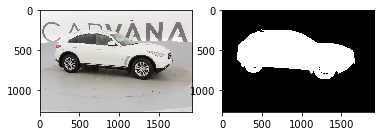

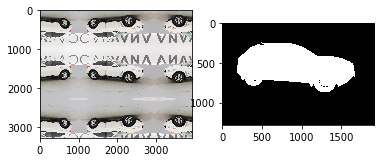

In [37]:
def pad_image(image, pad_width, mode='symmetric'):
    """
    Padding the image for prediction, the mode is 
    same as the one in numpy.pad
    
    # Args 
    image:      PIL Image or array
    pad_width:  the width to pad around the image
    
    # Return
                PIL Image padded
    """
    array = img_to_array(image)
    padding = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))
    padded_array = np.pad(array, padding, mode=mode)
    padded_image = array_to_img(padded_array)
    return padded_image
%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_ = pad_image(image_, 1000)
show_image_and_mask(image_, mask_)

In [ ]:
# predict 1 patch 250ms

519 ms ± 798 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


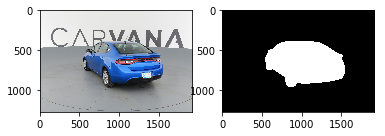

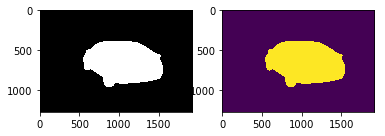

In [154]:
def predict_on_patch(model, image, pad_width, mode, image_size, input_size, output_size, verbose=0):
    """
    Predict the mask patch by patch since the valid padding is used in train
    
    # Args:
    image:      PIL Image
    mode:       Method to pading the image. The same as np.pad
    image_size: The size to perform prediction, (w, h). e.g (906, 640)
    input_size: The size of image to feed into the network
    output_size:The output mask size, which is smaller than input because the edge of the 
                input is discard gradually
    
    """
    image = imresize(image, image_size[::-1])
    if pad_width != 0:
        image = pad_image(image, pad_width, mode)
    array = img_to_array(image) / 255
    mask = np.zeros(image_size[::-1])
    h, w = array.shape[0:2]
    mask_h, mask_w = mask.shape
    
    patch_width = output_size[0]
    patch_high = output_size[1]
    assert patch_width == patch_high, 'Output_size must be square'
    
    input_patch_width = input_size[0]
    input_patch_high = input_size[1]
    assert input_patch_width == input_patch_high, 'Input_size must be square'
    
    if verbose:
        plt.figure()
        plt.imshow(image)
        plt.show()
    
    # Function for judge the position of the patch
    def _is_last_col():
        return patch_width * i + input_patch_width > w
    def _is_last_row():
        return patch_high * j + input_patch_high > h
    
    # Predict patch by patch
    for i in range(int(np.ceil((w - input_patch_width) / patch_width)) + 1):
        for j in range(int(np.ceil((h - input_patch_high) / patch_high)) + 1):
            
            xs = i * patch_width
            xe = xs + input_patch_width
            ys = j * patch_high
            ye = ys + input_patch_high
            
            if (_is_last_row()):
                ys = h - input_patch_high - 1
                ye = h - 1
            if (_is_last_col()):
                xs = w - input_patch_width - 1
                xe = w - 1
                
            if verbose:
                print ('Now processing ({}, {}), ({}, {}).'.
                       format(xs, ys, xe, ye))
            
            # Predict the patch
            patch = array[ys:ye, xs:xe]
            patch = patch[None,:,:,:]
            output_patch = model.predict(patch, batch_size=1)
            
            if verbose:
                show_image_and_mask(patch[0], output_patch[0,:,:,0])
            
            # Fill the mask
            xs = i * patch_width
            xe = (i + 1) * patch_width
            ys = j * patch_high
            ye = (j + 1) * patch_high
            if (_is_last_row()):
                ys = mask_h - patch_high - 1
                ye = mask_h - 1
            if (_is_last_col()):
                xs = mask_w - patch_width - 1
                xe = mask_w - 1
            mask[ys:ye, xs:xe] = output_patch[0,:,:,0]
            
    return mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[0])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

output_dims = (1280, 1280)
%timeit mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

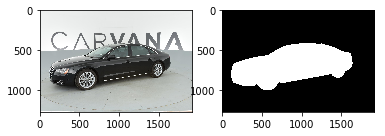

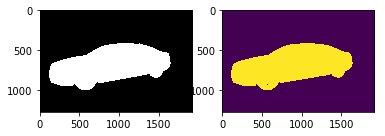

In [144]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

# Symmetric padding, (mirror)
mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[2])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
mask_pred_ = model.predict(val_images[0][None,:,:,:])
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(val_masks[0][:,:,0], mask_pred_[0,:,:,0])

1.07 s ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


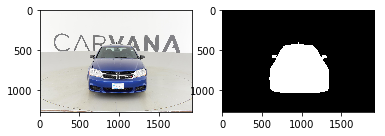

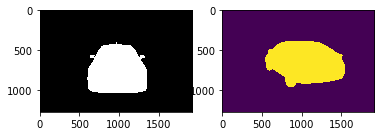

In [155]:
def mirror_average_prediction(model, image, pad_width, mode, image_size, input_size, output_size):
    threshold = None
    image2 = image.transpose(Image.FLIP_LEFT_RIGHT)
    mask = predict_on_patch(model, image, pad_width, mode, image_size, input_size, output_size)
    mask2 = predict_on_patch(model, image2, pad_width, mode, image_size, input_size, output_size)
    mask = mask + np.fliplr(mask2)
    mask /= 2.
    if threshold:
        mask[mask>=threshold] = 1
        mask[mask<threshold] = 0
    return mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[2])
show_image_and_mask(image_, mask_)
mask_ = imresize(mask_, image_size[::-1])
%timeit mask_pred_ = mirror_average_prediction(model, image_, 0, 'edge', image_size, input_dims, output_dims)
show_image_and_mask(mask_, mask_pred_)

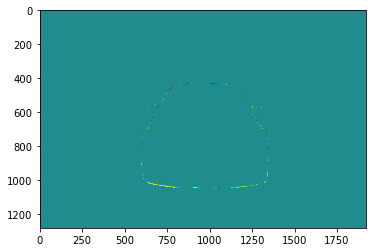

In [43]:
plt.figure()
plt.imshow(mask_[:,:,0] / 255. - mask_pred_)
plt.show()
# Yellow: indicate fasle negtive
# Purper: indicate fasle positve

In [ ]:
mask_[200,200]

In [ ]:
(mask_ / 255.)[200,200,1]

In [ ]:
mask_pred_[200,200]

In [151]:
def cal_dice_coef(mask1, mask2):
    """
    calculate dice coefficient
    
    mask1:    Groundtruth lable, size + channel
    mask2:    Predicted lable, 
    """
    if mask1.max() > 1:
        mask1 = (mask1 / 255.)[:,:,0]
    mask1 = mask1.astype(int)
    threshold = 0.5
    if threshold:
        mask2[mask2>=threshold] = 1
        mask2[mask2<threshold] = 0
        mask2 = mask2.astype(int)
    intersection = mask1 * mask2
    return 2. * intersection.sum() / (mask1 + mask2).sum()
%time cal_dice_coef(mask_, mask_pred_)

CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 63.2 ms


0.9969730538045285

In [143]:
from data_utils import show_3_images, show_4_images

In [ ]:
# Calculate the dice coefficient on the validation set. The mask is smaller than the image.
def val_dice_coef(model, image_pairs, 
                  pad_width, image_size, input_size, output_size, val_step=0):
    dices = []
    if val_step == 0:
        assert len(image_pair) == 2, 'Image_pair should be a tuple.'
        images, masks = image_pairs
        for image, mask in tqdm(zip(images, masks)):
            mask_pred = model.predict(image[None,:,:,:])
            mask_pred = mask_pred[0,:,:,:]
            dice = cal_dice_coef(mask, mask_pred)
            dices.append(dice)
            # Show image, mask, prediction and difference
            show_4_images(image, mask[:,:,0], mask_pred[:,:,0], 
                          mask[:,:,0]-mask_pred[:,:,0])
    else:
        for i in tqdm(range(val_step)):
            val_images, val_masks = next(val_gen)
            mask_preds = model.predict(val_images)
            for image, mask, mask_pred in zip(val_images, val_masks, mask_preds):
                dice = cal_dice_coef(mask, mask_pred)
                dices.append(dice)
                show_4_images(image, mask[:,:,0], mask_pred[:,:,0], 
                              mask[:,:,0]-mask_pred[:,:,0])
    return dices

val_gen = data_gen_small(data_dir, mask_dir, validation_images, batch_size, 
                         input_dims, transforms=transforms, in_order=True)
dices = val_dice_coef(model, val_gen, 0, image_size, input_dims, 
                      output_dims, val_step=1018 // 2)

In [122]:
np.mean(dices)

0.99705208787463706

In [ ]:
def remove_artifacts(mask):
    """
    # Args:
     mask:      2D array
    """
    mask = np.round(mask)
    mask = mask.astype(np.int32)
    label = label_shape(mask, connectivity=2)
    
    (h, w) = mask.shape
    bottom_left = label[h-1,0]
    bottom_right = label[h-1,w-1]
    if bottom_left == bottom_right and bottom_left != 0:
        # Remove bottom blob
        mask[label==bottom_left] = 0
    label[label==bottom_left] = 0
    # Remove other small area
    label_num = label.max()
    areas = [(label == i + 1).sum() for i in range(label_num + 1)]
    areas_max = max(areas)
    # retain the largest blob, remove all other blobs
    for i in range(1, label_num + 1):
        if areas[i-1] != areas_max:
            mask[label==i] = 0
    return mask

ix_ = np.random.randint(0, 1018)
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[ix_])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'edge',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_3_images(mask_, mask_pred_, mask_[:,:,0] / 255. - mask_pred_)

mask_processed_ = remove_artifacts(mask_pred_)

plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_processed_)
plt.show()

0de66245f268_13.jpg
520 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


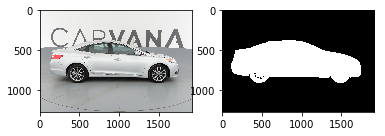

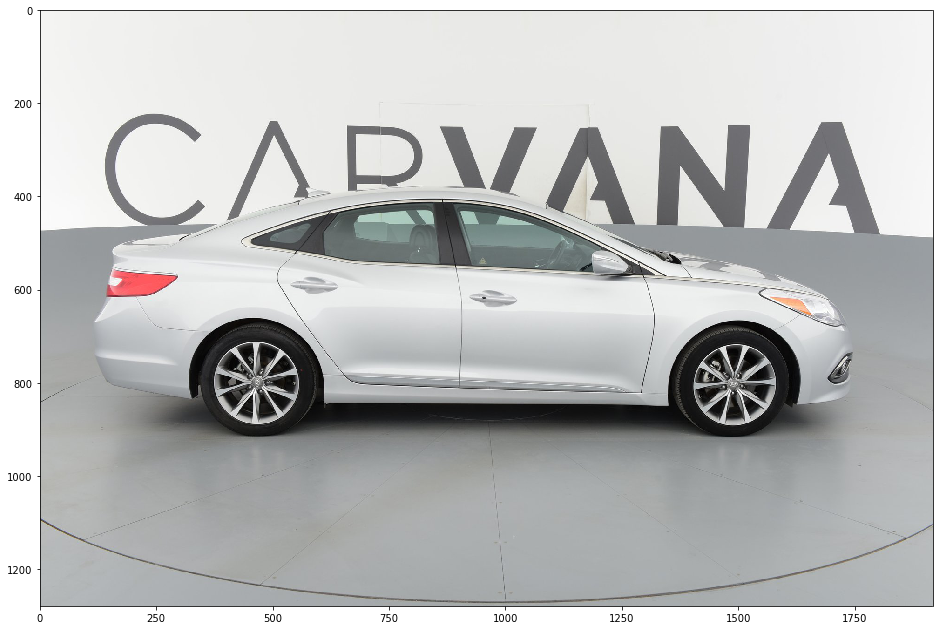

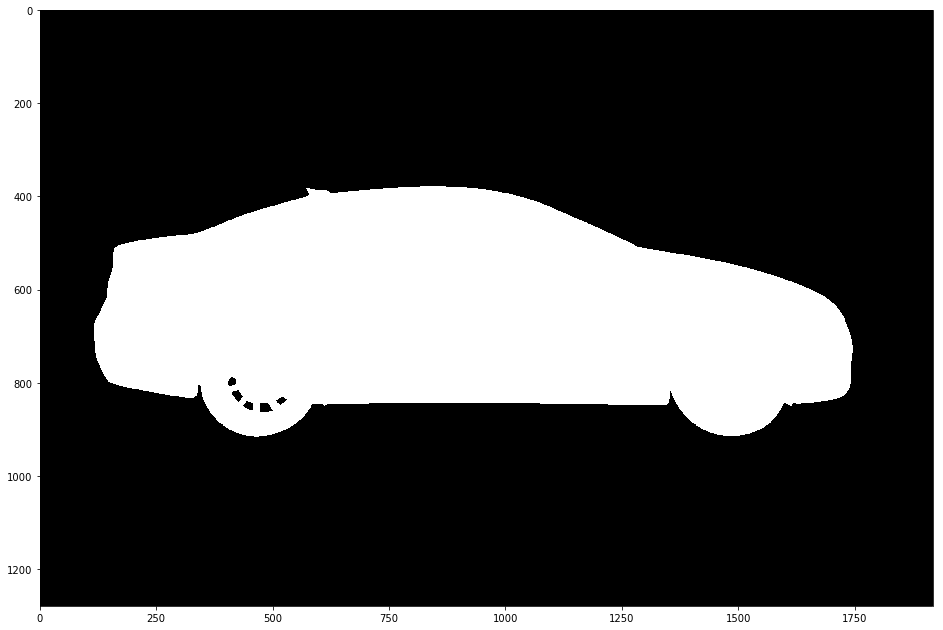

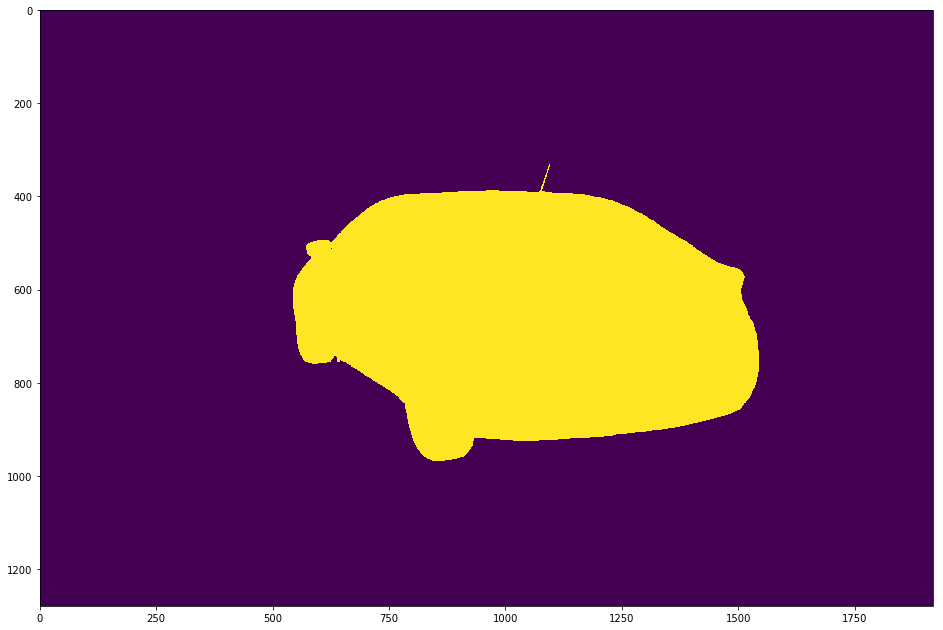

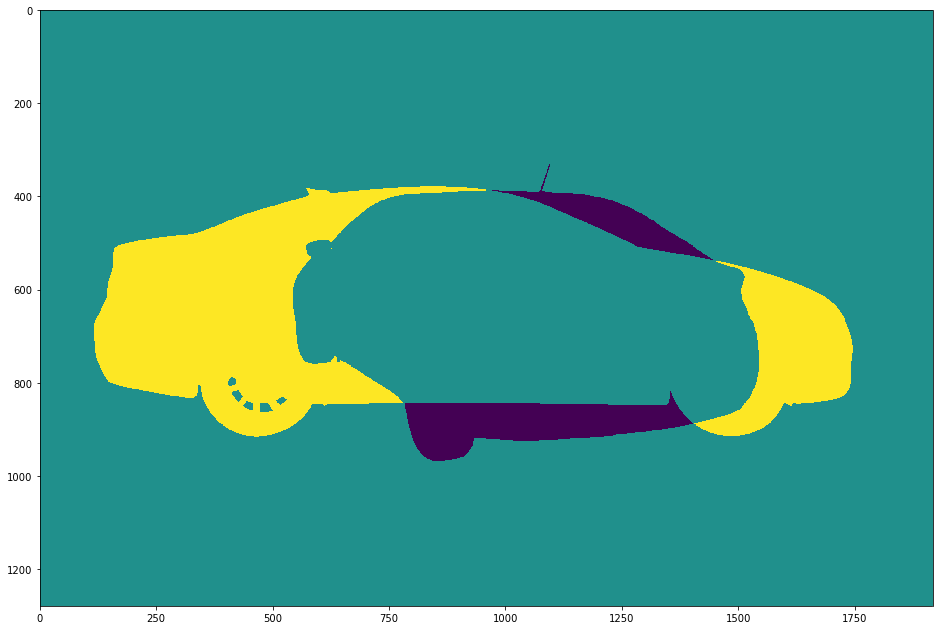

In [156]:
ix_ = np.random.randint(0, 1018)
print (validation_images[ix_])
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[ix_])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

%timeit mask_pred_ = predict_on_patch(model, image_, 0, 'edge',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0

plt.figure(figsize=(16, 12))
plt.imshow(image_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_[:,:,0] / 255. - mask_pred_)
plt.show()
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car

In [74]:
def sort_dices(dices, image_names):
    return sorted(dices), [image_name for _, image_name in sorted(zip(dices, image_names))]

dices_sort, validation_images_sort = sort_dices(dices, validation_images)

In [99]:
validation_images_sort[0]

'3a7a8f03e713_09.jpg'

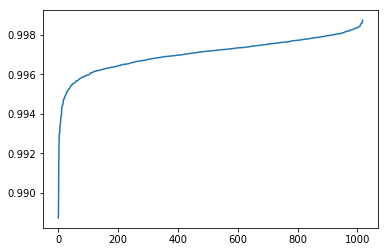

In [77]:
plt.figure()
plt.plot(dices_sort)
plt.show()

In [119]:
def show_diff(image, mask, mask_pred, save_to=None, show=True):
    plt.figure(figsize=(20, 16 * 4))
    plt.subplot(411)
    plt.imshow(image)
    plt.subplot(412)
    plt.imshow(mask)
    plt.subplot(413)
    plt.imshow(mask_pred)
    plt.subplot(414)
    plt.imshow(mask - mask_pred)
    if save_to:
        plt.savefig(save_to)
    if show:
        plt.show()
    plt.close()

3a7a8f03e713_09.jpg
0.988713059883
0.990461993602


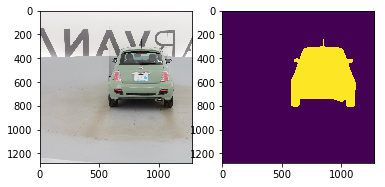

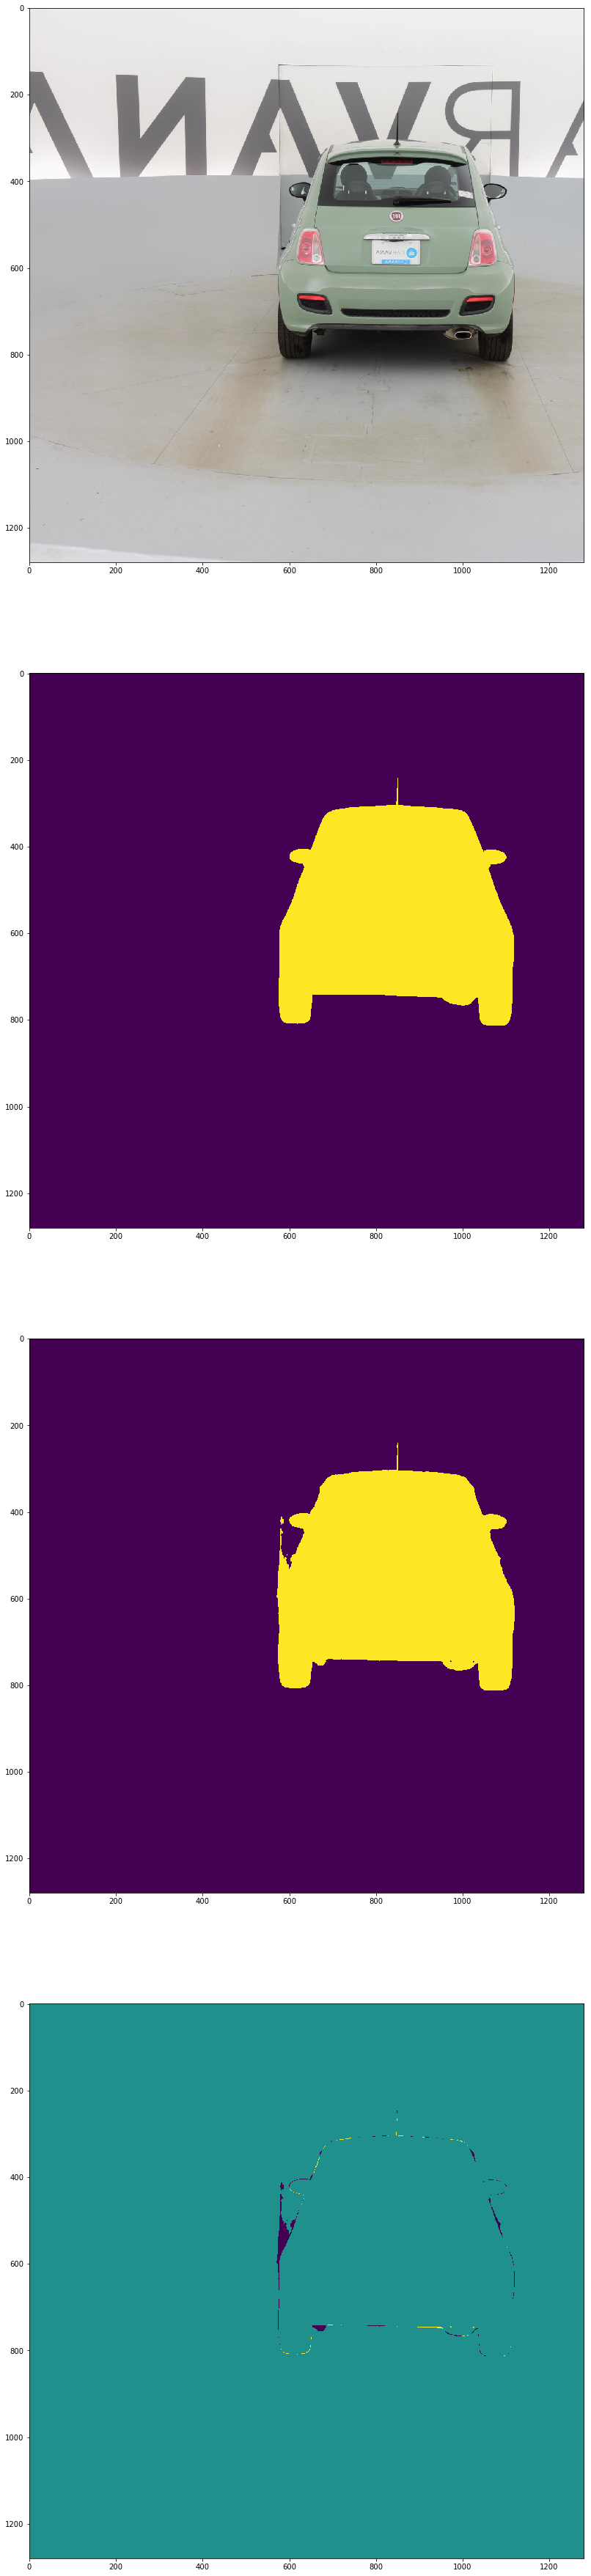

In [120]:
ix_ = 0
print (validation_images_sort[ix_])
print (dices_sort[ix_])

val_gen_ = data_gen_small(data_dir, mask_dir, [validation_images_sort[ix_]], 1, 
                         input_dims, transforms=transforms, in_order=True)
image_, mask_ = next(val_gen_)

show_image_and_mask(image_[0], mask_[0,:,:,0])

mask_pred_ = model.predict(image_)

print (cal_dice_coef(mask_[0], mask_pred_[0]))

mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0

show_diff(image_[0], mask_[0,:,:,0], mask_pred_[0,:,:,0], 
          save_to= tmp_dir + 'result/' + 'top-' + str(ix_ + 1) + '_error_' + validation_images_sort[ix_])
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car

3a7a8f03e713_09.jpg
0.988713059883
0.987600291758
bf9932f7aca8_14.jpg
0.988844447132
0.991796686875
bec93f7ddb19_09.jpg
0.99146514936
0.992094089587
5fb012d30fd9_13.jpg
0.992553063193
0.991901997203
86c10c8c6206_09.jpg
0.993010723559
0.993010723559
a46baa0b3ac0_09.jpg
0.993015744248
0.992541642589
a46baa0b3ac0_10.jpg
0.99330847762
0.993678157848
99639c826ea5_01.jpg
0.993469386962
0.993482886261
0d53224da2b7_12.jpg
0.993592002139
0.993512823169
f8b6f4c39204_10.jpg
0.993870835446
0.994295719694
eb91b1c659a0_02.jpg
0.993893481719
0.994994778034
3c6acfceb552_12.jpg
0.993928826372
0.993833710437
11fcda0a9e1c_09.jpg
0.994293905847
0.994510392193
2f39abb12388_14.jpg
0.994406553107
0.99367009174
2cb06c1f5bb1_10.jpg
0.994428262725
0.995067630184
430f0cb5666c_04.jpg
0.9944388038
0.993829945349
56023a17481b_09.jpg
0.994493433785
0.994338584736
878738468f6b_09.jpg
0.994630761878
0.994878911897
3afec4b5ac07_09.jpg
0.994747085218
0.995182333721
c53e374fdd72_13.jpg
0.994754022193
0.993728020658


/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


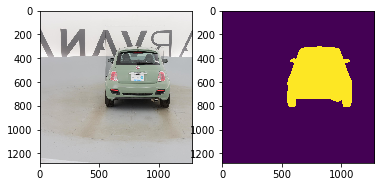

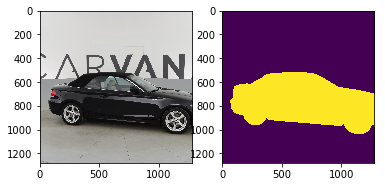

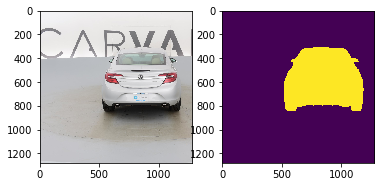

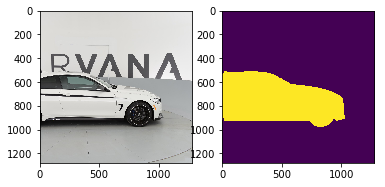

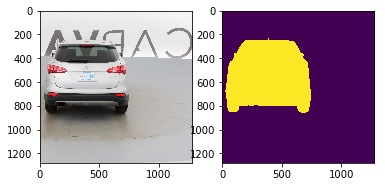

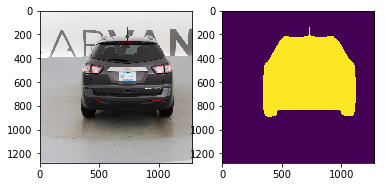

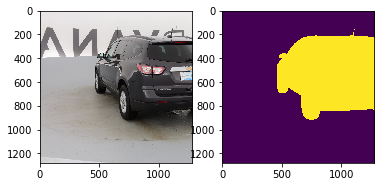

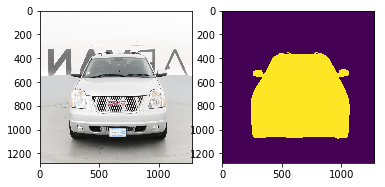

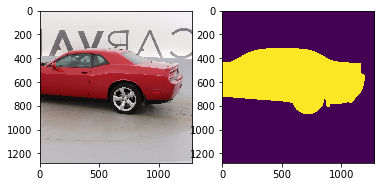

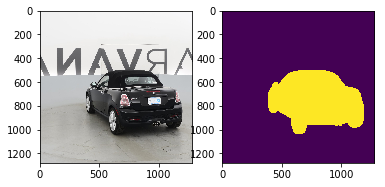

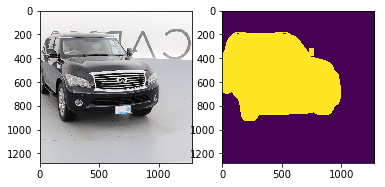

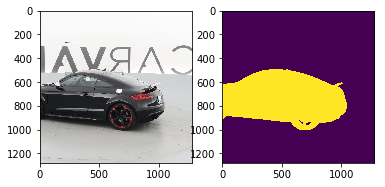

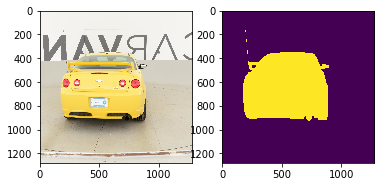

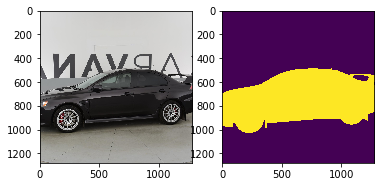

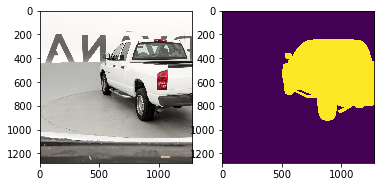

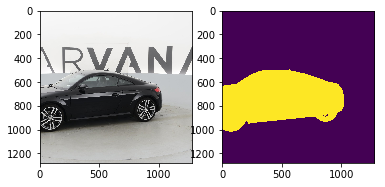

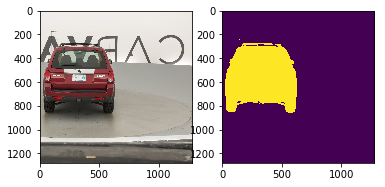

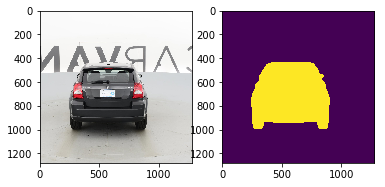

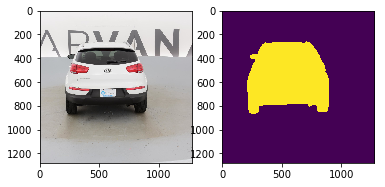

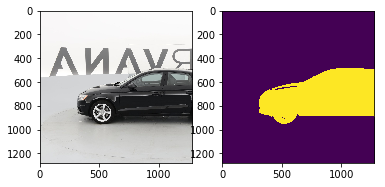

In [121]:
def show_top_error(model, imin, imax, dices, validation_images_sort, 
                   input_dims, transforms, save=True, show=False):
    for ix_ in range(imin, imax):
        print (validation_images_sort[ix_])
        print (dices_sort[ix_])

        val_gen_ = data_gen_small(data_dir, mask_dir, [validation_images_sort[ix_]], 1, 
                                 input_dims, transforms=transforms, in_order=True)
        image_, mask_ = next(val_gen_)

        show_image_and_mask(image_[0], mask_[0,:,:,0])

        mask_pred_ = model.predict(image_)

        print (cal_dice_coef(mask_[0], mask_pred_[0]))

        mask_pred_[mask_pred_>0.5] = 1
        mask_pred_[mask_pred_<0.5] = 0

        save_to = (tmp_dir + 'result/' + 'top-' + str(ix_ + 1).zfill(3) + 
                '_error_' + validation_images_sort[ix_])
        
        show_diff(image_[0], mask_[0,:,:,0], mask_pred_[0,:,:,0], 
                  save_to=save_to, show=show)
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car
show_top_error(model, 0, 20, dices, validation_images_sort, 
               input_dims, transforms)

In [ ]:
# Calculate the dice coefficient on the validation set. The original image will be predict part by part.
# Calculate the dice coefficient on the validation set. The original image will be predict part by part.
def val_dice_coef2(model, validation_images, data_dir, mask_dir, 
                   pad_width, mode, image_size, input_size, output_size):
    dices = []
    masks_pred = []
    for image in tqdm(validation_images):
        image, mask = read_image_and_mask(data_dir, mask_dir, image)
        mask = imresize(mask, image_size[::-1]) / 255.
        mask_pred = mirror_average_prediction(model, image, 
                                               pad_width, mode, image_size, input_dims, output_dims)
        # Show image, mask, prediction and difference
        show_4_images(image, mask[:,:,0], mask_pred, mask[:,:,0]-mask_pred[:,:])
        dices.append(cal_dice_coef(mask[:,:,0], mask_pred))
    return dices
dices = val_dice_coef2(model, validation_images, data_dir, mask_dir,
                           0, 'edge', image_size, input_dims, output_dims)

In [ ]:
%lprun -f val_dice_coef2 val_dice_coef2(model, validation_images[0:10], data_dir, mask_dir, 0, 'edge', image_size, input_dims, output_dims)

In [125]:
np.mean(dices)

0.99697233755232484

In [ ]:
def val_dice_coef3(model, validation_images, data_dir, mask_dir, 
                   pad_width, mode, image_size, input_size, output_size):
    dices = []
    masks_pred = []
    for image in tqdm(validation_images):
        image, mask = read_image_and_mask(data_dir, mask_dir, image)
        mask = imresize(mask, image_size[::-1]) / 255.
        mask_pred = predict_on_patch(model, image, 0, 'edge',image_size, input_dims, output_size)
        # Show image, mask, prediction and difference
        show_4_images(image, mask[:,:,0], mask_pred, mask[:,:,0]-mask_pred)
        dices.append(cal_dice_coef(mask[:,:,0], mask_pred))
    return dices
dices = val_dice_coef3(model, validation_images, data_dir, mask_dir,
                           0, 'edge', image_size, input_dims, output_dims)

In [134]:
np.mean(dices)
# This is smaller than mirrow average

0.9968392512100811

In [138]:
test_images = os.listdir(test_dir)
len(test_images)

100064

In [206]:
test_images.sort()

In [209]:
test_images[0]

'0004d4463b50_01.jpg'

In [142]:
%%time
image_ = load_img(test_dir + test_images[0])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 510 µs


In [181]:
def rle_encode(mask):
    pixels = mask.flatten()
    
    # Set begining and end to 0 for simplicity
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs [1::2] = runs[1::2] - runs[:-1:2]
    
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def generate_one_record(image_names, mask): 
    rle_code = rle_encode(mask)
    record = image_names + ',' + rle_to_string(rle_code)
    return record

In [ ]:
def generate_test(model, test_images, test_dir, pad_width, 
                  mode, image_size, input_size, output_size):
    
    report_per = 100
    
    submission_path = tmp_dir + 'submission.csv'
    progress_path = tmp_dir + 'progress.log'
    
    if os.path.isfile(submission_path):
        os.remove(submission_path)
    if os.path.isfile(submission_path):
        os.remove(progress_path)
    
    with open(submission_path, 'w') as csvfile:
        csvfile.write('img,rle_mask\n')
        
    for i, image_name in enumerate(test_images):
        image = load_img(test_dir + image_name)
        mask = mirror_average_prediction(model, image, 
                                              pad_width, mode, image_size, input_dims, output_dims)
        mask = threshold_mask(mask)
        with open(submission_path, 'a') as csvfile:
            csvfile.write(generate_one_record(image_name, mask) + '\n')
            
        if i % report_per == 0:
            with open(progress_path, 'w') as progress_file:
                progress_file.write('progress is {}% \n'.format(i / len(test_images) * 100))
            
generate_test(model, test_images, test_dir, \
              0, 'edge', image_size, input_dims, output_dims)